**CNN model for PTB dataset:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
df_1 = pd.read_csv("/content/drive/MyDrive/ECG Heartbeat Categorization Dataset/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("/content/drive/MyDrive/ECG Heartbeat Categorization Dataset/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

In [ ]:
class_counts = df.iloc[:, -1].value_counts()
print("Number of normal samples:", class_counts[0])
print("Number of abnormal samples:", class_counts[1])


Number of normal samples: 4046
Number of abnormal samples: 10506


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

In [ ]:
Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [ ]:
def get_model():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model


In [ ]:
model = get_model()
file_path = "/content/drive/MyDrive/Saved_CNN_Models_PTB/CNN_model1_weights.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d_32 (Conv1D)          (None, 183, 16)           96        
                                                                 
 conv1d_33 (Conv1D)          (None, 179, 16)           1296      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 89, 16)           0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 89, 16)            0         
                                                                 
 conv1d_34 (Conv1D)          (None, 87, 32)            1568      
                                                           

In [ ]:
history = model.fit(X, Y, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

Epoch 1/1000

Epoch 1: val_acc improved from -inf to 0.77082, saving model to /content/drive/MyDrive/Saved_CNN_Models_PTB/CNN_model1_weights.h5
328/328 - 19s - loss: 0.5297 - acc: 0.7319 - val_loss: 0.4691 - val_acc: 0.7708 - lr: 0.0010 - 19s/epoch - 58ms/step
Epoch 2/1000

Epoch 2: val_acc improved from 0.77082 to 0.87382, saving model to /content/drive/MyDrive/Saved_CNN_Models_PTB/CNN_model1_weights.h5
328/328 - 16s - loss: 0.4178 - acc: 0.8037 - val_loss: 0.3406 - val_acc: 0.8738 - lr: 0.0010 - 16s/epoch - 48ms/step
Epoch 3/1000

Epoch 3: val_acc did not improve from 0.87382
328/328 - 16s - loss: 0.3153 - acc: 0.8755 - val_loss: 0.3915 - val_acc: 0.8446 - lr: 0.0010 - 16s/epoch - 48ms/step
Epoch 4/1000

Epoch 4: val_acc improved from 0.87382 to 0.92189, saving model to /content/drive/MyDrive/Saved_CNN_Models_PTB/CNN_model1_weights.h5
328/328 - 16s - loss: 0.2637 - acc: 0.8986 - val_loss: 0.2350 - val_acc: 0.9219 - lr: 0.0010 - 16s/epoch - 50ms/step
Epoch 5/1000

Epoch 5: val_acc imp

In [ ]:
model.save('/content/drive/MyDrive/Saved_CNN_Models_PTB/CNN_model1.h5')


In [ ]:
pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

91/91 [==============================] - 1s 10ms/step


In [ ]:
f1 = f1_score(Y_test, pred_test)

In [ ]:
print("Test f1 score : %s "% f1)

Test f1 score : 0.9947693770803614 


In [ ]:
acc = accuracy_score(Y_test, pred_test)

In [ ]:
print("Test accuracy score : %s "% acc)

Test accuracy score : 0.992442459635864 


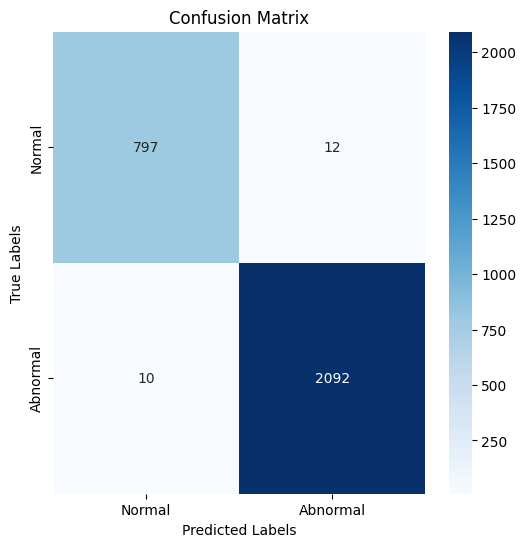


Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       809
    Abnormal       0.99      1.00      0.99      2102

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# Create the confusion matrix
cm = confusion_matrix(Y_test, pred_test)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

target_names = ["Normal", "Abnormal"]
print("\nClassification Report:\n", classification_report(Y_test, pred_test, target_names=target_names))


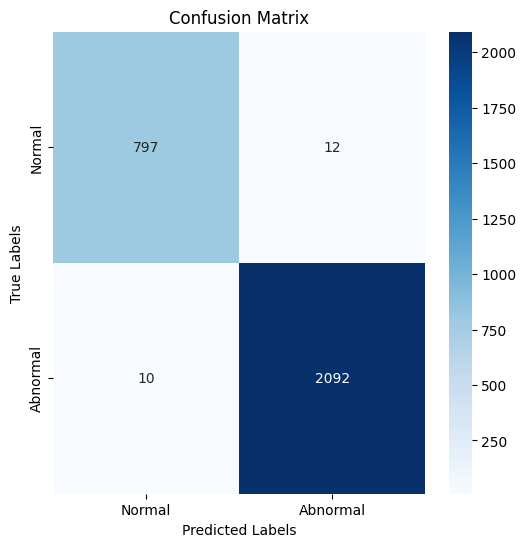


Class 'Normal' Metrics:
Precision: 0.9876
Recall: 0.9852
F1-score: 0.9864
Support: 809

Class 'Abnormal' Metrics:
Precision: 0.9943
Recall: 0.9952
F1-score: 0.9948
Support: 2102

Overall Accuracy: 0.992442459635864
Overall Precision: 0.9909525021084522
Overall Recall: 0.9902047493763665
Overall F1-score: 0.9905777578471114


In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision, recall, f1_score, support = precision_recall_fscore_support(Y_test, pred_test)

target_names = ["Normal", "Abnormal"]
for i, target_name in enumerate(target_names):
    print(f"\nClass '{target_name}' Metrics:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1_score[i]:.4f}")
    print(f"Support: {support[i]}")


# Calculate overall accuracy, precision, recall, and F1-score
acc = accuracy_score(Y_test, pred_test)
overall_precision = np.mean(precision)
overall_recall = np.mean(recall)
overall_f1_score = np.mean(f1_score)

print("\nOverall Accuracy:", acc)
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


In [ ]:
# To load model:
# from keras.models import load_model
# loaded_model = load_model('/content/drive/MyDrive/Saved_CNN_Models_PTB/CNN_model1.h5')
# history = loaded_model.history.history


In [ ]:
history = history.history

In [ ]:
!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

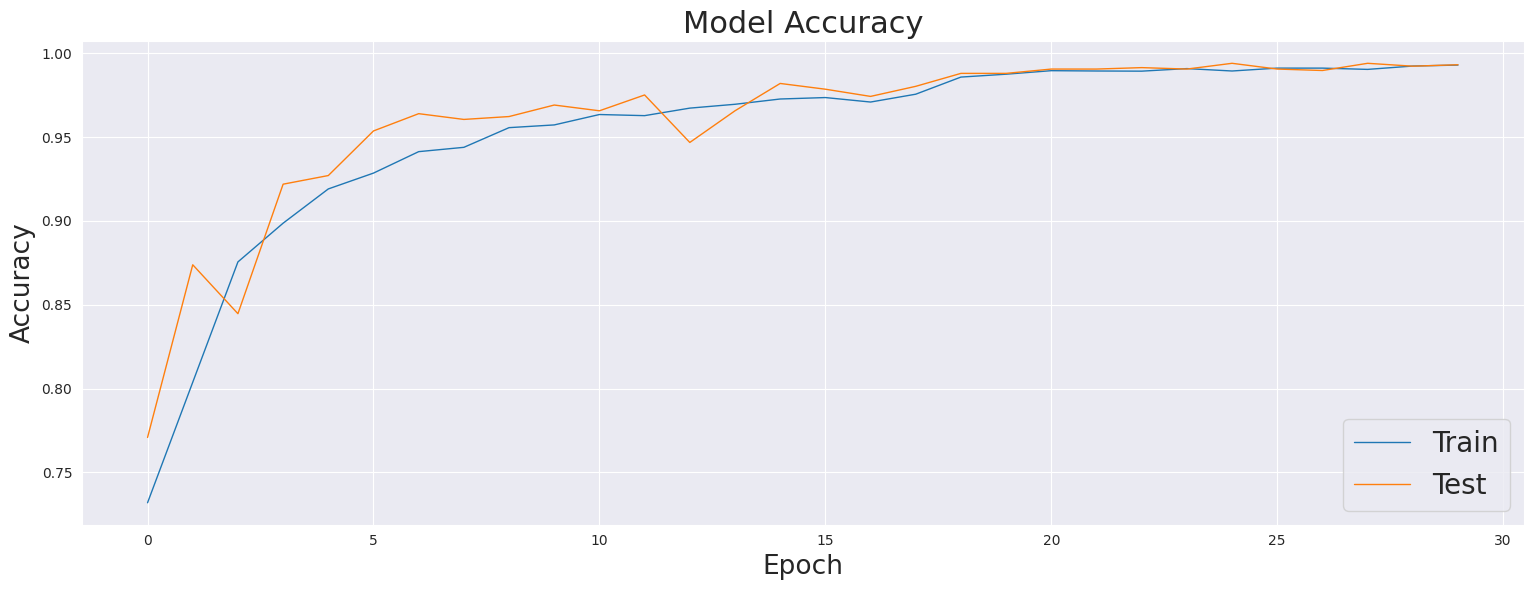

In [ ]:
# Plot training and validation accuracy
sns.set_style('darkgrid')

plt.subplot(1, 2, 1)
plt.plot(history['acc'], label='Train')
plt.plot(history['val_acc'], label='Test')
plt.title('Model Accuracy', fontsize=22)
plt.xlabel('Epoch', fontsize=19)
plt.ylabel('Accuracy', fontsize=19)
plt.legend(prop = {'size' : 20}, loc='lower right')
plt.tight_layout()
plt.show()

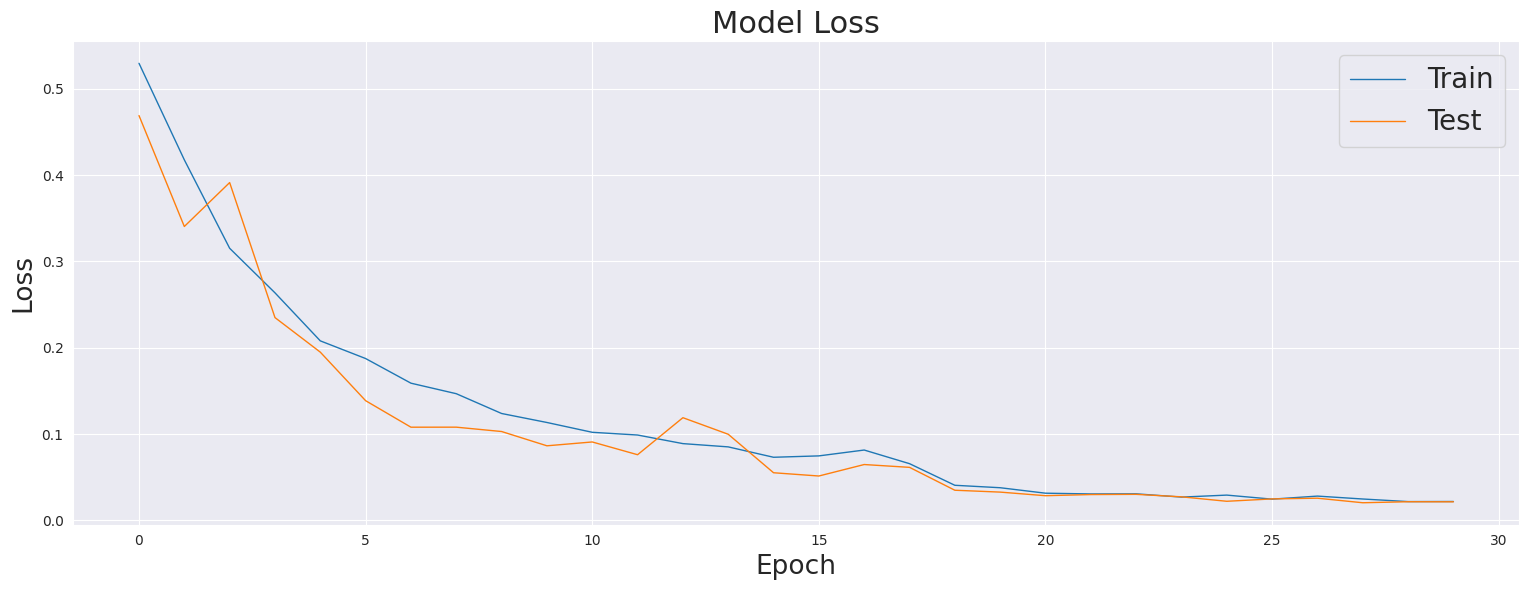

In [ ]:
# Plot training and validation loss
sns.set_style('darkgrid')

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Test')
plt.title('Model Loss', fontsize=22)
plt.xlabel('Epoch', fontsize=19)
plt.ylabel('Loss', fontsize=19)
plt.legend(prop = {'size' : 20}, loc='upper right')
plt.tight_layout()
plt.show()